In [1]:
import pyodbc                  # package that connects notebook to database
import pandas as pd            # package for data manipulation
import seaborn as sns          # package for visualziation
import statsmodels.api as sm   # package for lm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd
import plotly.express as px
from ipywidgets import interact, Dropdown
import numpy as np

(2) In the next two code cells we prepare a string consisting of arguments for the server (the computer we have been working with) and the driver (this is software the allows us to connect to a database provided that the database follows certain Open Database Connectivity (ODBC) standards). In most environments we would include sign-on credentials too, but as we have already logged into a TCU device via Windows authentication, the Server can use these credentials for access.

In [2]:
SERVER = 'STUSQL01.it.tcu.edu'
DRIVER= '{ODBC Driver 17 for SQL Server}'
connectionString = f'DRIVER={{ODBC Driver 17 for SQL Server}}; SERVER={SERVER}; TRUSTED_CONNECTION=yes'

In [3]:
cnxn = pyodbc.connect(connectionString)

# **General Overview**

## **1. General Metrics**


**General Metrics:**
- Total Revenue: $29M
- Total Profit: $9M
- Total Tax Amount: $2,349K
- Total Freight Cost: $734K
- Profit Margin: 42.84%


In [4]:
pd.options.display.float_format = '{:.4f}'.format

In [5]:
gm_query = '''
-- Further Transformation

WITH CTE_FactInternetSales
AS (SELECT
  ProductKey,
  OrderDateKey,
  DueDateKey,
  ShipDateKey,
  CustomerKey,
  PromotionKey,
  CurrencyKey,
  SalesTerritoryKey,
  SalesOrderNumber,
  SalesAmount,
  TotalProductCost,
  TaxAmt,
  Freight,
  SalesAmount - TotalProductCost - TaxAmt - Freight AS Profit,
  (SalesAmount - TotalProductCost - TaxAmt - Freight) / SalesAmount AS ProfitMargin,
  CONVERT(date, OrderDate) AS OrderDate,
  CONVERT(date, DueDate) AS DueDate,
  CONVERT(date, ShipDate) AS ShipDate,
  IIF(ShipDate > DueDate, 'Late', 'Normal') AS ShipStatus,
  DATEDIFF(D, OrderDate, ShipDate) + 3 TimeToArrive,
  DATEDIFF(D, OrderDate, ShipDate) TimeToShip
FROM [AdventureWorksDW2017].dbo.FactInternetSales)

-- General Metrics
SELECT 
SUM(SalesAmount) as TotalRevenue,
SUM(Profit) as TotalProfit, 
SUM(TaxAmt) as TotalTaxAmt,
SUM(Freight) as TotalFreightCost,
AVG(ProfitMargin) as ProfitMargin
FROM CTE_FactInternetSales


''' 
df_gm = pd.read_sql_query(gm_query, con=cnxn)
df_gm.head()

C:\Users\minhbpham\AppData\Local\Temp\ipykernel_5068\2338598011.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_gm = pd.read_sql_query(gm_query, con=cnxn)


,TotalRevenue,TotalProfit,TotalTaxAmt,TotalFreightCost,ProfitMargin
0,29358677.2207,8998219.8058,2348694.2301,733969.6091,0.4284


In [6]:
# Format values in US dollars and approximate to the nearest million or thousand
def format_dollars(value, divisor):
    return "${:,.0f}{}".format(value / divisor, 'K' if divisor == 1_000 else 'M')

# Print general metrics
print("General Metrics:")
print("Total Revenue: {}".format(format_dollars(df_gm['TotalRevenue'][0], 1_000_000)))
print("Total Profit: {}".format(format_dollars(df_gm['TotalProfit'][0], 1_000_000)))
print("Total Tax Amount: {}".format(format_dollars(df_gm['TotalTaxAmt'][0], 1_000)))
print("Total Freight Cost: {}".format(format_dollars(df_gm['TotalFreightCost'][0], 1_000)))
print("Profit Margin: {:.2%}".format(df_gm['ProfitMargin'][0]))

General Metrics:
Total Revenue: $29M
Total Profit: $9M
Total Tax Amount: $2,349K
Total Freight Cost: $734K
Profit Margin: 42.84%


## **2\. Time Series Analytics**

- **Yearly**
    
    - 2011: $7 Millions
    - 2012: $6 Millions
    - 2013: $14 Millions
    - 2014 and 2010: 2 Millions (December 2010 and January 2011)
- **Quarterly**
    
    - Better in the 2nd quarter then in the first quarter
- **Monthly**
    
    - Best: June, Octorber, November, December
    - Worst: January, Febuary, April

### **Cumulative Revenue Trend**

In [7]:
tsa_query = '''
WITH CTE_FactInternetSales
AS (SELECT
  ProductKey,
  OrderDateKey,
  DueDateKey,
  ShipDateKey,
  CustomerKey,
  PromotionKey,
  CurrencyKey,
  SalesTerritoryKey,
  SalesOrderNumber,
  SalesAmount,
  TotalProductCost,
  TaxAmt,
  Freight,
  SalesAmount - TotalProductCost - TaxAmt - Freight AS Profit,
  (SalesAmount - TotalProductCost - TaxAmt - Freight) / SalesAmount AS ProfitMargin,
  CONVERT(date, OrderDate) AS OrderDate,
  CONVERT(date, DueDate) AS DueDate,
  CONVERT(date, ShipDate) AS ShipDate,
  IIF(ShipDate > DueDate, 'Late', 'Normal') AS ShipStatus,
  DATEDIFF(D, OrderDate, ShipDate) + 3 TimeToArrive,
  DATEDIFF(D, OrderDate, ShipDate) TimeToShip
FROM [AdventureWorksDW2017].dbo.FactInternetSales),
CTE_DimDate
AS (SELECT
  DateKey,
  FullDateAlternateKey,
  DayNumberOfWeek,
  EnglishDayNameOfWeek,
  DayNumberOfMonth,
  DayNumberOfYear,
  WeekNumberOfYear,
  MonthNumberOfYear,
  EnglishMonthName AS MonthName,
  CalendarQuarter,
  CalendarYear,
  CalendarSemester,
  FiscalYear FiscalQuarter,
  FiscalSemester
FROM [AdventureWorksDW2017].dbo.DimDate),

-- Times Series Analytics

--SELECT 
--SalesOrderNumber,
--SalesAmount,
--TotalProductCost,
--TaxAmt,
--Freight,
--Profit,
--ProfitMargin,
--OrderDate,
--DayNumberOfWeek,
--EnglishDayNameOfWeek,
--DayNumberOfMonth,
--DayNumberOfYear,
--WeekNumberOfYear,
--MonthNumberOfYear,
--MonthName,
--CalendarQuarter, 
--CalendarYear, 
--CalendarSemester,
--FiscalQuarter,
--FiscalSemester
--FROM CTE_FactInternetSales
--JOIN CTE_DimDate
--ON  CTE_FactInternetSales.OrderDateKey = CTE_DimDate.DateKey, 




CTE
AS (SELECT
  CalendarYear,
  CalendarQuarter,
  MonthNumberOfYear,
  MonthName,
  SUM(SalesAmount) AS Revenue,
  LAG(SUM(SalesAmount)) OVER (ORDER BY CalendarYear, MonthName) AS PreviousRevenue,
  (SUM(SalesAmount) - LAG(SUM(SalesAmount)) OVER (ORDER BY CalendarYear, MonthName)) / SUM(SalesAmount) * 100 AS RevenueChangePercentage,
  SUM(Profit) AS Profit,
  LAG(SUM(Profit)) OVER (ORDER BY CalendarYear, MonthName) AS PreviousProfit,
  (SUM(Profit) - LAG(SUM(Profit)) OVER (ORDER BY CalendarYear, MonthName)) / SUM(Profit) * 100 AS ProfitChangePercentage,
  AVG(ProfitMargin) AS AVGProfitMargin
FROM CTE_FactInternetSales
JOIN CTE_DimDate
  ON CTE_FactInternetSales.OrderDateKey = CTE_DimDate.DateKey
GROUP BY CalendarYear,
         CalendarQuarter,
         MonthNumberOfYear,
         MonthName)

SELECT
  *,
  SUM(Revenue) OVER (ORDER BY CalendarYear, MonthNumberOfYear) AS CumulativeRevenue,
  SUM(Revenue) OVER (PARTITION BY CalendarYear ORDER BY CalendarYear, MonthNumberOfYear) AS YearlyCumulativeRevenue,
  --SUM(Revenue) OVER(partition by CalendarYear) as Yearly_Revenue,
  Revenue / (SUM(Revenue) OVER (PARTITION BY CalendarYear)) * 100 AS MonthlyRevenuePercentage
FROM CTE
ORDER BY 1, 2

''' 
df_tsa = pd.read_sql_query(tsa_query, con=cnxn)
# df_tsa.head()

C:\Users\minhbpham\AppData\Local\Temp\ipykernel_5068\2991550187.py:105: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tsa = pd.read_sql_query(tsa_query, con=cnxn)


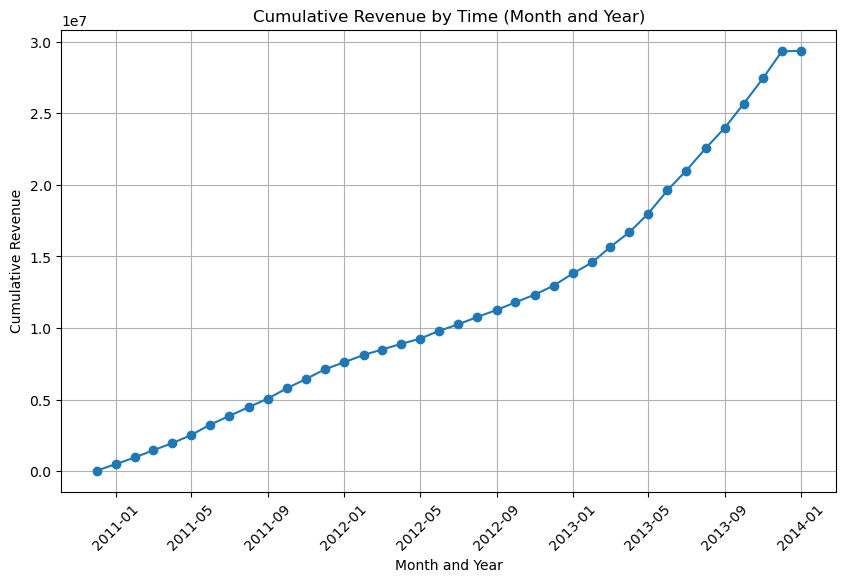

In [8]:
# Creating a new column for the combination of Year and Month
df_tsa['YearMonth'] = df_tsa.apply(lambda x: str(x['CalendarYear']) + '-' + str(x['MonthNumberOfYear']), axis=1)

# Sorting the values based on the new column and by year and month
df_tsa['YearMonth'] = pd.to_datetime(df_tsa['YearMonth'], format='%Y-%m')
df_tsa = df_tsa.sort_values('YearMonth')

# Plotting the cumulative revenue by time
plt.figure(figsize=(10, 6))
plt.plot(df_tsa['YearMonth'], df_tsa['CumulativeRevenue'], marker='o', linestyle='-')
plt.title('Cumulative Revenue by Time (Month and Year)')
plt.xlabel('Month and Year')
plt.ylabel('Cumulative Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [10]:
import plotly.graph_objects as go

# Filter the DataFrame for the required years
df_tsa = df_tsa[df_tsa['CalendarYear'].isin([2011, 2012, 2013])]

# Prompt the user to select a number
print("Please select a number:")
print("1. Revenue")
print("2. Profit")
print("3. AVG Profit Margin")
print("4. Monthly Revenue Percentage")

# Get user input for the selected number
selected_number = int(input("Enter the number corresponding to your choice: "))

# Map the selected number to the actual value
value_mapping = {
    1: 'Revenue',
    2: 'Profit',
    3: 'AVGProfitMargin',
    4: 'MonthlyRevenuePercentage'
}
selected_value = value_mapping.get(selected_number)

# Creating the interactive line graph with drill-down
fig = go.Figure()

# Define slightly darker colors
colors = ['rgba(255, 100, 100, 0.8)', 'rgba(100, 255, 100, 0.8)', 'rgba(100, 100, 255, 0.8)']
color_dict = {2011: colors[0], 2012: colors[1], 2013: colors[2]}

for year in df_tsa['CalendarYear'].unique():
    year_data = df_tsa[df_tsa['CalendarYear'] == year]
    fig.add_trace(go.Scatter(x=year_data['MonthName'], y=year_data[selected_value], mode='lines+markers', name=str(year), line=dict(color=color_dict[year])))

fig.update_layout(title='Monthly {} by Year and Month'.format(selected_value), xaxis_title='Month', yaxis_title=selected_value, width=700, height=600)
fig.show()


Please select a number:
1. Revenue
2. Profit
3. AVG Profit Margin
4. Monthly Revenue Percentage


**Monthly BreakDown (Part as whole)**

In [12]:
import plotly.express as px

# Filter for specific years
years = [2011, 2012, 2013]
df_tsa_filtered = df_tsa[df_tsa['CalendarYear'].isin(years)]

# Defining the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Converting the 'MonthName' column to a categorical data type with specified order
df_tsa_filtered['MonthName'] = pd.Categorical(df_tsa_filtered['MonthName'], categories=month_order, ordered=True)

# Sorting the DataFrame based on the categorical 'MonthName' column
df_tsa_filtered = df_tsa_filtered.sort_values('MonthName')

# Prompt the user to select a number
print("Please select a number:")
print("1. Revenue")
print("2. Profit")
print("3. AVG Profit Margin")
print("4. Monthly Revenue Percentage")

# Get user input for the selected number
selected_number = int(input("Enter the number corresponding to your choice: "))

# Map the selected number to the actual value
value_mapping = {
    1: 'Revenue',
    2: 'Profit',
    3: 'AVGProfitMargin',
    4: 'MonthlyRevenuePercentage'
}
selected_value = value_mapping.get(selected_number)

if selected_value not in df_tsa.columns:
    print("Invalid value selected. Please choose from the provided options.")
else:
    # Calculate the percentage dynamically based on the selected value
    df_tsa_filtered['Percentage'] = df_tsa_filtered[selected_value] / df_tsa_filtered[selected_value].sum() * 100

    # Create the sunburst chart with the selected value
    fig = px.sunburst(df_tsa_filtered, path=['CalendarYear', 'CalendarQuarter', 'MonthName'], values=selected_value, 
                      custom_data=['Percentage'], title=f'Part of whole of {selected_value} for Years 2011, 2012, 2013')

    fig.update_traces(textinfo='label+percent entry', insidetextorientation='radial')

    # Create the update menu
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {'method': 'update', 
                     'label': 'Revenue', 
                     'args': [{'values': [df_tsa_filtered['Revenue']]}]},
                    {'method': 'update', 
                     'label': 'Profit', 
                     'args': [{'values': [df_tsa_filtered['Profit']]}]},
                    {'method': 'update', 
                     'label': 'AVG_ProfitMargin', 
                     'args': [{'values': [df_tsa_filtered['AVGProfitMargin']]}]},
                    {'method': 'update', 
                     'label': 'Monthly_Revenue_Percentage', 
                     'args': [{'values': [df_tsa_filtered['MonthlyRevenuePercentage'], df_tsa_filtered['Percentage']]}]},
                ],
                'direction': 'down',
                'showactive': True,
            }
        ]
    )

    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), width=700, height=700)
    fig.show()


Please select a number:
1. Revenue
2. Profit
3. AVG Profit Margin
4. Monthly Revenue Percentage


**Monthly Revenue Breakdown (Comparison)**

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prompt the user to select a number
print("Please select a number:")
print("1. Revenue")
print("2. Profit")
print("3. AVGProfitMargin")
print("4. MonthlyRevenuePercentage")
print("5. RevenueChangePercentage")
print("6. ProfitChangePercentage")

# Get user input for the selected number
selected_number = int(input("Enter the number corresponding to your choice: "))

# Map the selected number to the actual value
value_mapping = {
    1: 'Revenue',
    2: 'Profit',
    3: 'AVGProfitMargin',
    4: 'MonthlyRevenuePercentage',
    5: 'RevenueChangePercentage',
    6: 'ProfitChangePercentage'
}

selected_value = value_mapping.get(selected_number)

if selected_value is None:
    print("Invalid value selected. Please choose from the provided options.")
else:
    # Create subplots with larger height
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('2011', '2012', '2013'))
    years = [2011, 2012, 2013]
    highlight_months = ['June', 'October', 'November', 'December']

    for i, year in enumerate(years):
        year_data = df_tsa[df_tsa['CalendarYear'] == year]
        sorted_data_lowest = year_data.nsmallest(3, selected_value)
        sorted_data_highest = year_data.nlargest(3, selected_value)
        colors = ['rgba(100, 100, 100, 0.7)'] * len(year_data)

        for index, row in sorted_data_lowest.iterrows():
            colors[year_data.index.get_loc(index)] = 'rgba(200, 50, 50, 0.8)'
        for index, row in sorted_data_highest.iterrows():
            colors[year_data.index.get_loc(index)] = 'rgba(50, 200, 50, 0.8)'

        fig.add_trace(go.Bar(x=year_data['MonthName'], y=year_data[selected_value], name=str(year), marker_color=colors), row=i + 1, col=1)

    fig.update_layout(height=800, width=800, title_text="Corresponding {} for Each Month (2011, 2012, 2013)".format(selected_value))
    fig.show()


Please select a number:
1. Revenue
2. Profit
3. AVGProfitMargin
4. MonthlyRevenuePercentage
5. RevenueChangePercentage
6. ProfitChangePercentage


---

## **3\. Product Analytics**

In [14]:
product_query = '''
-- Further Transformation
WITH CTE_FactInternetSales
AS (SELECT
  ProductKey,
  OrderDateKey,
  DueDateKey,
  ShipDateKey,
  CustomerKey,
  PromotionKey,
  CurrencyKey,
  SalesTerritoryKey,
  SalesOrderNumber,
  SalesAmount,
  TotalProductCost,
  TaxAmt,
  Freight,
  SalesAmount - TotalProductCost - TaxAmt - Freight AS Profit,
  (SalesAmount - TotalProductCost - TaxAmt - Freight) / SalesAmount AS ProfitMargin,
  CONVERT(date, OrderDate) AS OrderDate,
  CONVERT(date, DueDate) AS DueDate,
  CONVERT(date, ShipDate) AS ShipDate,
  IIF(ShipDate > DueDate, 'Late', 'Normal') AS ShipStatus,
  DATEDIFF(D, OrderDate, ShipDate) + 3 TimeToArrive,
  DATEDIFF(D, OrderDate, ShipDate) TimeToShip
FROM [AdventureWorksDW2017].dbo.FactInternetSales)
-------------------------------------------------------------------------------------------------------------------------------------------------------
,
CTE_DimProduct
AS (SELECT
  ProductKey,
  ProductAlternateKey,
  EnglishProductName AS ProductName,
  EnglishProductCategoryName AS CategoryName,
  EnglishProductSubcategoryName AS SubcategoryName,
  CASE
    WHEN EnglishProductName LIKE '%,%' AND
      EnglishProductCategoryName = 'Bikes' THEN LEFT(EnglishProductName, CHARINDEX(' ', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%,%' AND
      EnglishProductSubcategoryName LIKE '%Frames%' THEN LEFT(EnglishProductName, CHARINDEX('-', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%,%' THEN LEFT(EnglishProductName, CHARINDEX(',', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%/%' THEN LEFT(EnglishProductName, CHARINDEX('/', EnglishProductName) - 1)
    ELSE NULL
  END AS ModelName,
  SafetyStockLevel,
  ReorderPoint,
  Color,
  SizeRange,
  Weight
FROM [AdventureWorksDW2017].dbo.DimProduct
JOIN [AdventureWorksDW2017].dbo.DimProductSubcategory
  ON DimProduct.ProductSubcategoryKey = DimProductSubcategory.ProductSubcategoryKey
JOIN [AdventureWorksDW2017].dbo.DimProductCategory
  ON DimProductSubcategory.ProductCategoryKey = DimProductCategory.ProductCategoryKey
WHERE ListPrice IS NOT NULL)
-------------------------------------------------------------------------------------------------------------------------------------------------------
SELECT
  ProductName,
  CategoryName,
  SubcategoryName,
  ModelName,
  CAST(ROUND(SUM(SalesAmount), 0) AS int) AS Revenue,
  CAST(ROUND(SUM(Profit), 0) AS int) AS Profit,
  CAST(ROUND(AVG(Profit), 0) AS int) AS AVGProfit,
  AVG(ProfitMargin) AS ProfitMargin,
  COUNT(*) AS QuantitySold
FROM CTE_FactInternetSales
JOIN CTE_DimProduct
  ON CTE_FactInternetSales.ProductKey = CTE_DimProduct.ProductKey
GROUP BY ProductName,
         CategoryName,
         SubcategoryName,
         ModelName,
         SafetyStockLevel,
         ReorderPoint
ORDER BY Profit DESC
''' 
df_product = pd.read_sql_query(product_query, con=cnxn)

C:\Users\minhbpham\AppData\Local\Temp\ipykernel_5068\1709303439.py:78: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [16]:
df_product = df_product.fillna('NA')

In [17]:
idf_product = df_product.fillna('NA')

# Assuming df_product is your DataFrame

# Prompt the user to select a number
print("Please select a number:")
print("1. Revenue")
print("2. Profit")
print("3. AVGProfit")
print("4. ProfitMargin")
print("5. QuantitySold")

# Get user input for the selected number
selected_number = int(input("Enter the number corresponding to your choice: "))

# Map the selected number to the column names
column_mapping = {
    1: 'Revenue',
    2: 'Profit',
    3: 'AVGProfit',
    4: 'ProfitMargin',
    5: 'QuantitySold'
}

# Check if the selected number is valid
if selected_number not in column_mapping.keys():
    print("Invalid number selected. Please choose from the provided options.")
else:
    selected_column = column_mapping[selected_number]

    # Calculate the percentage dynamically based on the selected column
    df_product['RevenuePercentage'] = df_product[selected_column] / df_product[selected_column].sum() * 100

    # Create the sunburst chart with the selected column
    fig = px.sunburst(df_product, path=['CategoryName', 'SubcategoryName', 'ModelName'], values=selected_column,
                      custom_data=['RevenuePercentage'], title=f'{selected_column} Breakdown by Product')
    fig.update_traces(textinfo='label+percent entry', insidetextorientation='radial')
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), width=700, height=700)
    fig.show()


Please select a number:
1. Revenue
2. Profit
3. AVGProfit
4. ProfitMargin
5. QuantitySold


In [18]:
product_query2 = '''
-- Further Transformation
WITH CTE_FactInternetSales
AS (SELECT
  ProductKey,
  OrderDateKey,
  DueDateKey,
  ShipDateKey,
  CustomerKey,
  PromotionKey,
  CurrencyKey,
  SalesTerritoryKey,
  SalesOrderNumber,
  SalesAmount,
  TotalProductCost,
  TaxAmt,
  Freight,
  SalesAmount - TotalProductCost - TaxAmt - Freight AS Profit,
  (SalesAmount - TotalProductCost - TaxAmt - Freight) / SalesAmount AS ProfitMargin,
  CONVERT(date, OrderDate) AS OrderDate,
  CONVERT(date, DueDate) AS DueDate,
  CONVERT(date, ShipDate) AS ShipDate,
  IIF(ShipDate > DueDate, 'Late', 'Normal') AS ShipStatus,
  DATEDIFF(D, OrderDate, ShipDate) + 3 TimeToArrive,
  DATEDIFF(D, OrderDate, ShipDate) TimeToShip
FROM [AdventureWorksDW2017].dbo.FactInternetSales)
-------------------------------------------------------------------------------------------------------------------------------------------------------
,
CTE_DimDate
AS (SELECT
  DateKey,
  FullDateAlternateKey,
  DayNumberOfWeek,
  EnglishDayNameOfWeek,
  DayNumberOfMonth,
  DayNumberOfYear,
  WeekNumberOfYear,
  MonthNumberOfYear,
  EnglishMonthName AS MonthName,
  CalendarQuarter,
  CalendarYear,
  CalendarSemester,
  FiscalYear FiscalQuarter,
  FiscalSemester
FROM [AdventureWorksDW2017].dbo.DimDate)
-------------------------------------------------------------------------------------------------------------------------------------------------------
,
CTE_DimProduct
AS (SELECT
  ProductKey,
  ProductAlternateKey,
  EnglishProductName AS ProductName,
  EnglishProductCategoryName AS CategoryName,
  EnglishProductSubcategoryName AS SubcategoryName,
  CASE
    WHEN EnglishProductName LIKE '%,%' AND
      EnglishProductCategoryName = 'Bikes' THEN LEFT(EnglishProductName, CHARINDEX(' ', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%,%' AND
      EnglishProductSubcategoryName LIKE '%Frames%' THEN LEFT(EnglishProductName, CHARINDEX('-', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%,%' THEN LEFT(EnglishProductName, CHARINDEX(',', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%/%' THEN LEFT(EnglishProductName, CHARINDEX('/', EnglishProductName) - 1)
    ELSE NULL
  END AS ModelName,
  SafetyStockLevel,
  ReorderPoint,
  Color,
  SizeRange,
  Weight
FROM [AdventureWorksDW2017].dbo.DimProduct
JOIN [AdventureWorksDW2017].dbo.DimProductSubcategory
  ON DimProduct.ProductSubcategoryKey = DimProductSubcategory.ProductSubcategoryKey
JOIN [AdventureWorksDW2017].dbo.DimProductCategory
  ON DimProductSubcategory.ProductCategoryKey = DimProductCategory.ProductCategoryKey
WHERE ListPrice IS NOT NULL)
-------------------------------------------------------------------------------------------------------------------------------------------------------


SELECT 
CalendarYear,
ProductName,
CategoryName,
SubcategoryName,
ModelName,
CAST(ROUND(SUM(SalesAmount), 0) AS int)  as Revenue,
CAST(ROUND(SUM(Profit), 0) AS int)  as Profit,
CAST(ROUND(AVG(Profit),0) AS int) as AVGProfit,
AVG(ProfitMargin) as ProfitMargin,
COUNT(*) as QuantitySold
FROM CTE_FactInternetSales
JOIN CTE_DimProduct
ON CTE_FactInternetSales.ProductKey = CTE_DimProduct.ProductKey
JOIN CTE_DimDate
ON CTE_FactInternetSales.OrderDateKey = CTE_DimDate.DateKey
GROUP BY CalendarYear, ProductName,CategoryName, SubcategoryName, ModelName
ORDER BY CalendarYear, Profit DESC
''' 
df_product2 = pd.read_sql_query(product_query2, con=cnxn)

C:\Users\minhbpham\AppData\Local\Temp\ipykernel_5068\2375437123.py:97: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [19]:
df_product2 = df_product2.fillna('NA')

# Prompt the user to select a number
print("Please select a number:")
print("1. Revenue")
print("2. Profit")
print("3. AVGProfit")
print("4. ProfitMargin")
print("5. QuantitySold")

# Get user input for the selected number
selected_number = int(input("Enter the number corresponding to your choice: "))

# Map the selected number to the column names
column_mapping = {
    1: 'Revenue',
    2: 'Profit',
    3: 'AVGProfit',
    4: 'ProfitMargin',
    5: 'QuantitySold'
}

# Check if the selected number is valid
if selected_number not in column_mapping.keys():
    print("Invalid number selected. Please choose from the provided options.")
else:
    selected_column = column_mapping[selected_number]

    # Calculate the percentage dynamically based on the selected column
    df_product2['RevenuePercentage'] = df_product2[selected_column] / df_product2[selected_column].sum() * 100

    # Create the sunburst chart with the selected column and include the year in the path
    fig = px.sunburst(df_product2, path=['CalendarYear', 'CategoryName', 'SubcategoryName', 'ModelName'], values=selected_column,
                      custom_data=['RevenuePercentage'], title=f'{selected_column} Breakdown by Product')
    fig.update_traces(textinfo='label+percent entry', insidetextorientation='radial')
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), width=700, height=700)
    fig.show()


Please select a number:
1. Revenue
2. Profit
3. AVGProfit
4. ProfitMargin
5. QuantitySold


---

## **4\. Customer Analytics**

In [27]:
import pandas as pd
import pyodbc

# Prompt the user to select top or bottom
print("Please select an option:")
print("a. Top N%")
print("b. Bottom N%")

# Get user input for the selected option
selected_option = input("Enter the option (a or b): ")

# Validate user input
if selected_option.lower() not in ['a', 'b']:
    print("Invalid option selected. Please choose either 'a' or 'b'.")
else:
    # Prompt the user to enter the percentage
    try:
        percentage = float(input("Enter the percentage (e.g., 5 for top 5%): "))
    except ValueError:
        print("Invalid input. Please enter a numeric value for the percentage.")
        exit()

    # Determine whether to select top or bottom N%
    order_by = "desc" if selected_option.lower() == 'a' else "asc"

    # Your existing SQL query with modifications
    top_customer_query = f'''
    -- Further Transformation
    WITH CTE_FactInternetSales
    AS (SELECT
      ProductKey,
      OrderDateKey,
      DueDateKey,
      ShipDateKey,
      CustomerKey,
      PromotionKey,
      CurrencyKey,
      SalesTerritoryKey,
      SalesOrderNumber,
      SalesAmount,
      TotalProductCost,
      TaxAmt,
      Freight,
      SalesAmount - TotalProductCost - TaxAmt - Freight AS Profit,
      (SalesAmount - TotalProductCost - TaxAmt - Freight) / SalesAmount AS ProfitMargin,
      CONVERT(date, OrderDate) AS OrderDate,
      CONVERT(date, DueDate) AS DueDate,
      CONVERT(date, ShipDate) AS ShipDate,
      IIF(ShipDate > DueDate, 'Late', 'Normal') AS ShipStatus,
      DATEDIFF(D, OrderDate, ShipDate) + 3 TimeToArrive,
      DATEDIFF(D, OrderDate, ShipDate) TimeToShip
    FROM [AdventureWorksDW2017].dbo.FactInternetSales)
    -------------------------------------------------------------------------------------------------------------------------------------------------------
    ,
    CTE_DimCustomer
    AS (SELECT
      CustomerKey,
      GeographyKey,
      FirstName,
      LastName,
      BirthDate,
      DATEDIFF(YEAR, BirthDate, GETDATE()) AS Age,
      MaritalStatus,
      Gender,
      EnglishEducation AS Education,
      EnglishOccupation AS Occupation,
      YearlyIncome,
      TotalChildren,
      NumberChildrenAtHome,
      NumberCarsOwned,
      DateFirstPurchase,
      CommuteDistance
    FROM [AdventureWorksDW2017].dbo.DimCustomer)
    -------------------------------------------------------------------------------------------------------------------------------------------------------

    SELECT * FROM CTE_DimCustomer 
    WHERE CustomerKey in (
    -- List of customer who spent the most top/bottom N% Spender)
    SELECT CustomerKey FROM 
    (
    SELECT 
        CTE_DimCustomer.CustomerKey as CustomerKey, 
        SUM(Profit) as TotalRevenue,
        (PERCENT_RANK() OVER(ORDER BY SUM(Profit) {order_by}))*100 AS PercentRank 
    FROM CTE_FactInternetSales
    JOIN CTE_DimCustomer
    ON CTE_FactInternetSales.CustomerKey = CTE_DimCustomer.CustomerKey
    GROUP BY CTE_DimCustomer.CustomerKey
    ) b
    WHERE PercentRank <= {percentage}
    )
    '''
    
    # Read data into a DataFrame
    df_customer = pd.read_sql_query(top_customer_query, con=cnxn)


Please select an option:
a. Top N%
b. Bottom N%


C:\Users\minhbpham\AppData\Local\Temp\ipykernel_5068\2712985801.py:95: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [31]:
allowed_columns = ["Age", "MaritalStatus", "Gender", "Education", "Occupation", "YearlyIncome", "TotalChildren", "NumberChildrenAtHome", "NumberCarsOwned", "DateFirstPurchase", "CommuteDistance"]

# Prompt the user to select a number
print("Please select a number:")
for i, column in enumerate(allowed_columns, start=1):
    print(f"{i}. {column}")

# Get user input for the selected number
selected_number = int(input("Enter the number corresponding to your choice: "))

# Map the selected number to the column names
selected_column = allowed_columns[selected_number - 1] if 1 <= selected_number <= len(allowed_columns) else None

# Check if the selected number is valid
if selected_column is None:
    print("Invalid number selected. Please choose from the provided options.")
else:
    if pd.api.types.is_numeric_dtype(df_customer[selected_column]):
        selected_data = df_customer[selected_column]
        column_mean = selected_data.mean()
        column_median = selected_data.median()
        column_mode = selected_data.mode()[0]
        column_std = selected_data.std()

        print(f"Mean: {column_mean}\nMedian: {column_median}\nMode: {column_mode}\nStandard Deviation: {column_std}")

        # Create a histogram and lines for mean and median
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=df_customer[selected_column], name='Histogram'))
        fig.add_trace(go.Scatter(x=[column_mean, column_mean], y=[0, 100], mode='lines', name='Mean'))
        fig.add_trace(go.Scatter(x=[column_median, column_median], y=[0, 100], mode='lines', name='Median', line=dict(dash='dash')))
        fig.update_layout(title_text=f'Histogram with Mean and Median Lines of {selected_column}')

    else:
        fig = px.bar(df_customer[selected_column].value_counts(), x=df_customer[selected_column].value_counts().index, 
                     y=df_customer[selected_column].value_counts().values, 
                     title=f'Count of each category in {selected_column}')

    fig.show()


Please select a number:
1. Age
2. MaritalStatus
3. Gender
4. Education
5. Occupation
6. YearlyIncome
7. TotalChildren
8. NumberChildrenAtHome
9. NumberCarsOwned
10. DateFirstPurchase
11. CommuteDistance


Mean: 75329.72972972973
Median: 70000.0
Mode: 40000.0
Standard Deviation: 39315.35880158576
